# XLNet version 1

Hate speech identification project, D7047E <br>
Binary text classification task using pretrained XLNet models

In [1]:
""" 
%pip install numpy
%pip install torch
%pip install torchvision
%pip install sentencepiece
%pip install transformers
%pip install datasets
%pip install evaluate
%pip install accelerate
%pip install imbalanced-learn
"""

# PyTorch
import torch
import torchvision

# Hugging Face
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import datasets
import evaluate

# Misc
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Set up loaders 
import sys; sys.path.append("..")
import proj_dataset
proj_dataset.FOLDERSPATH = r'..\\datasets'

# Set up cudas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available(): torch.cuda.empty_cache()
print(f"using {device}")

using cuda


c:\Users\hanne\Desktop\d7047e\Project\XLNetModel\..\proj_dataset.py:18: UserWarning: Disabling panda dataframe warnings, to enable comment out lines below
  warnings.warn("Disabling panda dataframe warnings, to enable comment out lines below")


In [2]:
# aux files
path_output = r"trained\\"

# Constants
GLOBAL_SEED = 1337
TOKENIZER_MAX_LENGTH = 128
torch.manual_seed(GLOBAL_SEED)

tokenizer_config = {
    "padding": "max_length", 
    "truncation": "longest_first",
    "max_length": TOKENIZER_MAX_LENGTH,
}

In [3]:
train_df, val_df = proj_dataset._load_solid_set(size=100_000, tr_split_perc=0.8)
test_df_1 = proj_dataset._load_olid_test_set()
test_df_2 = proj_dataset._load_hasoc_test_set()
print(train_df.shape)
print(val_df.shape)
print(test_df_1.shape)
print(test_df_2.shape)

Loaded 100000 lines from file_off.xlsx to ensure sufficient randomness, cap: 50000
Loaded 100000 lines from file_not.xlsx to ensure sufficient randomness, cap: 50000
Loaded 13240 lines from ..\\datasets\\OLID\\OLID_Tain.txt
Loaded 5852 lines from english_dataset.tsv
Loaded 1153 lines from hasoc2019_en_test-2919.tsv
(80000, 2)
(20000, 2)
(13240, 2)
(7005, 2)


In [4]:
tokenizer = XLNetTokenizer.from_pretrained(
    'xlnet-base-cased',
    device=device
)

def tokenize_examples(examples):
    return tokenizer(examples["text"], **tokenizer_config)

In [5]:
# Load 
def convert_sets(s):
    s = s.rename(columns={"sentence":"text", "label1":"label"})
    ds = Dataset.from_dict(s)
    ds = ds.map(tokenize_examples, batched=True)
    return ds

In [6]:
train_set = convert_sets(train_df)
val_set = convert_sets(val_df)
test_set_1 = convert_sets(test_df_1)
test_set_2 = convert_sets(test_df_2)

print(train_set)
print(val_set)
print(test_set_1)
print(test_set_2)

Map:   0%|          | 0/80000 [00:00<?, ? examples/s]

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13240 [00:00<?, ? examples/s]

Map:   0%|          | 0/7005 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 80000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 20000
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 13240
})
Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7005
})


In [7]:
def getTrainLabelDistrib(ds):
    labels_dist = {}
    for e in ds:
        lab = e["label"] 
        if not lab in labels_dist: labels_dist[lab] = 0
        else: labels_dist[lab] += 1

    print(labels_dist)

In [8]:
#getTrainLabelDistrib(train_set)
#getTrainLabelDistrib(val_set)
#getTrainLabelDistrib(test_set_1)
#getTrainLabelDistrib(test_set_2)

In [9]:
# Model 
# docs: https://huggingface.co/docs/transformers/model_doc/xlnet

xlnet_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", 
    num_labels=2
)
xlnet_model.to(device)

print(xlnet_model.config)
print(next(xlnet_model.parameters()).is_cuda)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.40.2",
  "untie_r": true,
  "use_mems_eval": true,
  "use_mems_train": false,
  "vocab_size": 32000
}

True


In [11]:
# Fine-tuning
# https://huggingface.co/docs/transformers/training

metric = evaluate.load("accuracy")
def compute_model_metrics(eval_pred):
    global metric
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)


device_batch_size = 32
grad_steps = 2
calc_steps = len(train_set) // (device_batch_size * grad_steps * 5) 


tr_args = TrainingArguments(
    do_train=True, do_eval=True, evaluation_strategy="epoch", output_dir=path_output,
    
    logging_steps=calc_steps, # For larger size dataset
    eval_accumulation_steps=10, # To prevent cuda OOM after training
    per_device_eval_batch_size=device_batch_size,
    per_device_train_batch_size=device_batch_size,
    bf16=True, 
    # dataloader_pin_memory=True, dataloader_num_workers=8, # Load data on GPU
    #fp16=True,

    num_train_epochs = 7, 
    gradient_accumulation_steps=grad_steps,
    weight_decay=0.1,
    save_strategy="no",
    # use_cpu=True
)

trainer = Trainer(
    model=xlnet_model,
    args=tr_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    compute_metrics=compute_model_metrics
)
trainer.train()

  0%|          | 0/8750 [00:00<?, ?it/s]

{'loss': 0.024, 'grad_norm': 0.015222004614770412, 'learning_rate': 4.8571428571428576e-05, 'epoch': 0.2}
{'loss': 0.0294, 'grad_norm': 0.7302464246749878, 'learning_rate': 4.714285714285714e-05, 'epoch': 0.4}
{'loss': 0.0248, 'grad_norm': 0.05608579143881798, 'learning_rate': 4.5714285714285716e-05, 'epoch': 0.6}
{'loss': 0.0156, 'grad_norm': 0.029661787673830986, 'learning_rate': 4.428571428571428e-05, 'epoch': 0.8}
{'loss': 0.0128, 'grad_norm': 0.39592063426971436, 'learning_rate': 4.2857142857142856e-05, 'epoch': 1.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.012622741982340813, 'eval_accuracy': 0.99745, 'eval_runtime': 58.322, 'eval_samples_per_second': 342.924, 'eval_steps_per_second': 10.716, 'epoch': 1.0}
{'loss': 0.0087, 'grad_norm': 0.0157177671790123, 'learning_rate': 4.1428571428571437e-05, 'epoch': 1.2}
{'loss': 0.0091, 'grad_norm': 0.026947589591145515, 'learning_rate': 4e-05, 'epoch': 1.4}
{'loss': 0.0102, 'grad_norm': 0.04409029334783554, 'learning_rate': 3.857142857142858e-05, 'epoch': 1.6}
{'loss': 0.0058, 'grad_norm': 0.008663573302328587, 'learning_rate': 3.7142857142857143e-05, 'epoch': 1.8}
{'loss': 0.007, 'grad_norm': 0.014832334592938423, 'learning_rate': 3.571428571428572e-05, 'epoch': 2.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.013237766921520233, 'eval_accuracy': 0.9979, 'eval_runtime': 57.709, 'eval_samples_per_second': 346.566, 'eval_steps_per_second': 10.83, 'epoch': 2.0}
{'loss': 0.0057, 'grad_norm': 0.01556894090026617, 'learning_rate': 3.428571428571429e-05, 'epoch': 2.2}
{'loss': 0.0057, 'grad_norm': 0.017705420032143593, 'learning_rate': 3.285714285714286e-05, 'epoch': 2.4}
{'loss': 0.0061, 'grad_norm': 0.024551911279559135, 'learning_rate': 3.142857142857143e-05, 'epoch': 2.6}
{'loss': 0.0071, 'grad_norm': 0.020124591886997223, 'learning_rate': 3e-05, 'epoch': 2.8}
{'loss': 0.0056, 'grad_norm': 0.016912806779146194, 'learning_rate': 2.857142857142857e-05, 'epoch': 3.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.007693163119256496, 'eval_accuracy': 0.9985, 'eval_runtime': 57.794, 'eval_samples_per_second': 346.057, 'eval_steps_per_second': 10.814, 'epoch': 3.0}
{'loss': 0.0049, 'grad_norm': 0.01155016664415598, 'learning_rate': 2.714285714285714e-05, 'epoch': 3.2}
{'loss': 0.0058, 'grad_norm': 0.025853067636489868, 'learning_rate': 2.5714285714285714e-05, 'epoch': 3.4}
{'loss': 0.0048, 'grad_norm': 0.013756386004388332, 'learning_rate': 2.4285714285714288e-05, 'epoch': 3.6}
{'loss': 0.0034, 'grad_norm': 0.010133565403521061, 'learning_rate': 2.2857142857142858e-05, 'epoch': 3.8}
{'loss': 0.0044, 'grad_norm': 0.010265562683343887, 'learning_rate': 2.1428571428571428e-05, 'epoch': 4.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.016242433339357376, 'eval_accuracy': 0.9975, 'eval_runtime': 58.15, 'eval_samples_per_second': 343.938, 'eval_steps_per_second': 10.748, 'epoch': 4.0}
{'loss': 0.0046, 'grad_norm': 0.6688699722290039, 'learning_rate': 2e-05, 'epoch': 4.2}
{'loss': 0.0041, 'grad_norm': 0.017884202301502228, 'learning_rate': 1.8571428571428572e-05, 'epoch': 4.4}
{'loss': 0.0033, 'grad_norm': 0.013853367418050766, 'learning_rate': 1.7142857142857145e-05, 'epoch': 4.6}
{'loss': 0.0019, 'grad_norm': 0.008667383342981339, 'learning_rate': 1.5714285714285715e-05, 'epoch': 4.8}
{'loss': 0.0022, 'grad_norm': 0.005284450948238373, 'learning_rate': 1.4285714285714285e-05, 'epoch': 5.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.00882373284548521, 'eval_accuracy': 0.9988, 'eval_runtime': 57.7326, 'eval_samples_per_second': 346.425, 'eval_steps_per_second': 10.826, 'epoch': 5.0}
{'loss': 0.0034, 'grad_norm': 0.011829114519059658, 'learning_rate': 1.2857142857142857e-05, 'epoch': 5.2}
{'loss': 0.0094, 'grad_norm': 0.016215050593018532, 'learning_rate': 1.1428571428571429e-05, 'epoch': 5.4}
{'loss': 0.0036, 'grad_norm': 0.007878201082348824, 'learning_rate': 1e-05, 'epoch': 5.6}
{'loss': 0.0037, 'grad_norm': 0.008109837770462036, 'learning_rate': 8.571428571428573e-06, 'epoch': 5.8}
{'loss': 0.0009, 'grad_norm': 0.004970792215317488, 'learning_rate': 7.142857142857143e-06, 'epoch': 6.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.007150772958993912, 'eval_accuracy': 0.9982, 'eval_runtime': 57.7311, 'eval_samples_per_second': 346.434, 'eval_steps_per_second': 10.826, 'epoch': 6.0}
{'loss': 0.0025, 'grad_norm': 0.005762224085628986, 'learning_rate': 5.7142857142857145e-06, 'epoch': 6.2}
{'loss': 0.0022, 'grad_norm': 0.005673717241734266, 'learning_rate': 4.285714285714286e-06, 'epoch': 6.4}
{'loss': 0.0007, 'grad_norm': 0.005067917052656412, 'learning_rate': 2.8571428571428573e-06, 'epoch': 6.6}
{'loss': 0.0002, 'grad_norm': 0.00397880282253027, 'learning_rate': 1.4285714285714286e-06, 'epoch': 6.8}
{'loss': 0.0007, 'grad_norm': 0.0033890309277921915, 'learning_rate': 0.0, 'epoch': 7.0}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.00764233386144042, 'eval_accuracy': 0.9989, 'eval_runtime': 57.8975, 'eval_samples_per_second': 345.438, 'eval_steps_per_second': 10.795, 'epoch': 7.0}
{'train_runtime': 4476.7089, 'train_samples_per_second': 125.092, 'train_steps_per_second': 1.955, 'train_loss': 0.0069872004623923985, 'epoch': 7.0}


TrainOutput(global_step=8750, training_loss=0.0069872004623923985, metrics={'train_runtime': 4476.7089, 'train_samples_per_second': 125.092, 'train_steps_per_second': 1.955, 'total_flos': 3.988323913728e+16, 'train_loss': 0.0069872004623923985, 'epoch': 7.0})

In [12]:
predictions = trainer.predict(test_set_1)
preds = np.argmax(predictions.predictions, axis=-1)
labels_t = {"0":0, "1":0}
labels_p = {"0":0, "1":0}
for i in range(len(predictions.predictions)):
    #print(predictions.label_ids[i], preds[i], predictions.predictions[i]) # Debug overfitting
    labels_t[str(predictions.label_ids[i])] += 1
    labels_p[str(preds[i])] += 1
print(f"True labels {labels_t}")
print(f"Predicted labels {labels_p}")
loss_his = {"tr_loss":[], "val_loss":[]}
for e in trainer.state.log_history:
    if "loss" in e:
        loss_his["tr_loss"].append(e["loss"])
    elif "eval_loss" in e:
        loss_his["val_loss"].append(e["eval_loss"])
metric = evaluate.combine(["accuracy", "f1", "precision", "recall", "BucketHeadP65/confusion_matrix"])
metric.compute(predictions=preds, references=predictions.label_ids)

  0%|          | 0/414 [00:00<?, ?it/s]

True labels {'0': 4400, '1': 8840}
Predicted labels {'0': 5399, '1': 7841}


{'accuracy': 0.7778700906344411,
 'f1': 0.823691625202326,
 'precision': 0.8761637546231348,
 'recall': 0.7771493212669683,
 'confusion_matrix': array([[3429,  971],
        [1970, 6870]], dtype=int64)}

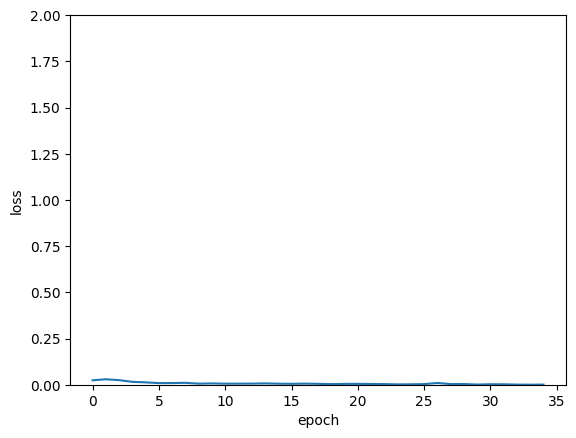

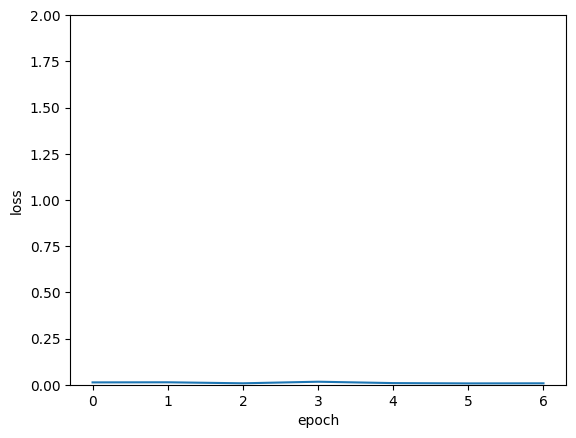

In [13]:
plt.plot(loss_his["tr_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()

plt.plot(loss_his["val_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()

In [14]:
predictions = trainer.predict(test_set_2)
preds = np.argmax(predictions.predictions, axis=-1)
labels_t = {"0":0, "1":0}
labels_p = {"0":0, "1":0}
for i in range(len(predictions.predictions)):
    #print(predictions.label_ids[i], preds[i], predictions.predictions[i]) # Debug overfitting
    labels_t[str(predictions.label_ids[i])] += 1
    labels_p[str(preds[i])] += 1
print(f"True labels {labels_t}")
print(f"Predicted labels {labels_p}")

loss_his = {"tr_loss":[], "val_loss":[]}
for e in trainer.state.log_history:
    if "loss" in e:
        loss_his["tr_loss"].append(e["loss"])
    elif "eval_loss" in e:
        loss_his["val_loss"].append(e["eval_loss"])

metric = evaluate.combine(["accuracy", "f1", "precision", "recall", "BucketHeadP65/confusion_matrix"])
metric.compute(predictions=preds, references=predictions.label_ids)

  0%|          | 0/219 [00:00<?, ?it/s]

True labels {'0': 2549, '1': 4456}
Predicted labels {'0': 3913, '1': 3092}


{'accuracy': 0.6088508208422555,
 'f1': 0.6369899311075782,
 'precision': 0.777490297542044,
 'recall': 0.5394973070017953,
 'confusion_matrix': array([[1861,  688],
        [2052, 2404]], dtype=int64)}

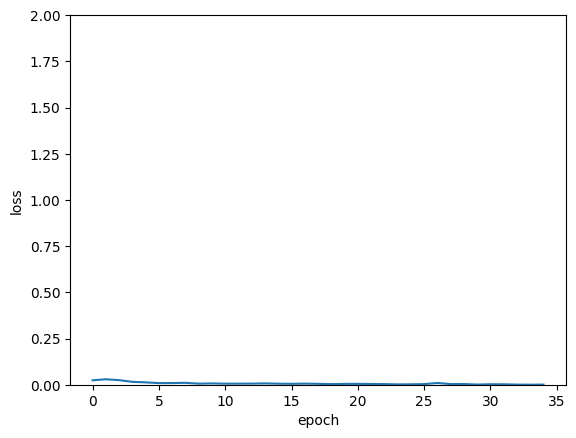

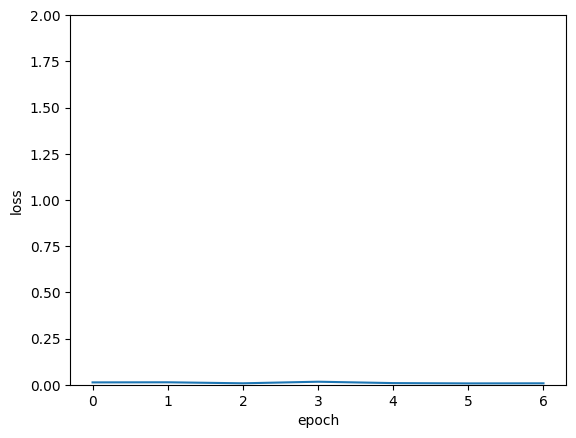

In [15]:
plt.plot(loss_his["tr_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()

plt.plot(loss_his["val_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()